# Lecture 4 - K-fold CV for CART model

## Load the CCHS data form epi7913A package

In [12]:
library(magrittr)

full_data<-epi7913A::cchs %>% dplyr::slice_sample(prop=0.01)
head(full_data)
dim(full_data)

,age,sex,CANHEARTbin,householdsize,education,maritalstatus,immigration,houseincome
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>
1,7,2,0,1,4,2,0,2
2,4,1,0,4,2,3,0,1
3,6,2,1,1,4,1,0,2
4,7,2,1,2,1,3,0,1
5,2,2,1,2,4,1,0,3
6,4,1,1,5,4,3,0,1


[1] 100   8

## Define the outcome variable

In [13]:
# define the outcome variable
voutcome <- "CANHEARTbin"

## Define the parallelisation parameters:
### - makeCluster(5) allocates 5 CPUs
### - clusterExport() sets the parallel environment to share *full_data* and *voutcome* variables

In [14]:
cl<-parallel::makeCluster(5)
parallel::clusterExport(cl, c("full_data", "voutcome"), envir = environment() )

## Calculate the mean performance of K-fold cross validation:
#### - Create K folds
#### - For each fold i, designate data in the remaining K-1 folds for training and those in fold i for testing
#### - Perform model optimization on the training data
#### - Obtain predictions on the test fold using the optimal model found
#### - Calculate the logloss of predictions made

In [15]:
# this remains the same as the serial code (the previous notebook)
ll.mean<-mean(parallel::parSapply(cl, caret::createFolds(full_data[, voutcome], k=5), function(x)
{
  testInds <- x
  trnInds <- setdiff(1:nrow(full_data), testInds)
  
  train_data <- full_data[trnInds,] 
  test_data <- full_data[testInds,]
  
  best_model<-sdgm::cart.bestmodel.bin(train_data, voutcome, n_iter=5)

  preds<-predict(best_model, test_data)

  if (!is.null(preds))
  {
    test_ll<- MLmetrics::LogLoss(preds, test_data[,voutcome] ) 
  } else  {
    test_ll<-NA
    print("Logloss calculation failed")
  }
}))

## shutdown the parallel environment when done

In [11]:
# shutdown the parallel environment when done
parallel::stopCluster(cl)

ERROR: Error in summary.connection(connection): invalid connection


## Printout the results

In [7]:
print(ll.mean, na.rm=T)

[1] 0.6828715


## Now train the final model

In [8]:
  final_model<-sdgm::cart.bestmodel.bin(full_data, voutcome, n_iter=5)


 Best Parameters Found: 
Round = 4	minsplit = 17.0000	minbucket = 10.0000	cp = 0.02574797	maxdepth = 13.0000	Value = -0.6281097 


## Show the final model

In [9]:
print(final_model)

$model
n= 100 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 100 24.840000 0.5400000  
   2) age=6,7 46 10.717390 0.3695652 *
   3) age=1,2,3,4,5 54 11.648150 0.6851852  
     6) householdsize=1,3 24  5.958333 0.5416667 *
     7) householdsize=2,4,5 30  4.800000 0.8000000  
      14) age=3,4,5 18  4.000000 0.6666667 *
      15) age=1,2 12  0.000000 1.0000000 *

$params
$params$perf
[1] -0.6281097

$params$minsplit
minsplit 
      17 

$params$minbucket
minbucket 
       10 

$params$maxdepth
maxdepth 
      13 

$params$cp
        cp 
0.02574797 


$outcome
[1] "CANHEARTbin"

$factorList
$factorList$age
[1] "1" "2" "3" "4" "5" "6" "7"

$factorList$sex
[1] "1" "2"

$factorList$householdsize
[1] "1" "2" "3" "4" "5"

$factorList$education
[1] "1" "2" "3" "4"

$factorList$maritalstatus
[1] "1" "2" "3"

$factorList$houseincome
[1] "1" "2" "3"


$predictors
[1] "age"           "sex"           "householdsize" "education"    
[5] "maritalstatus" "immigration"   "hous

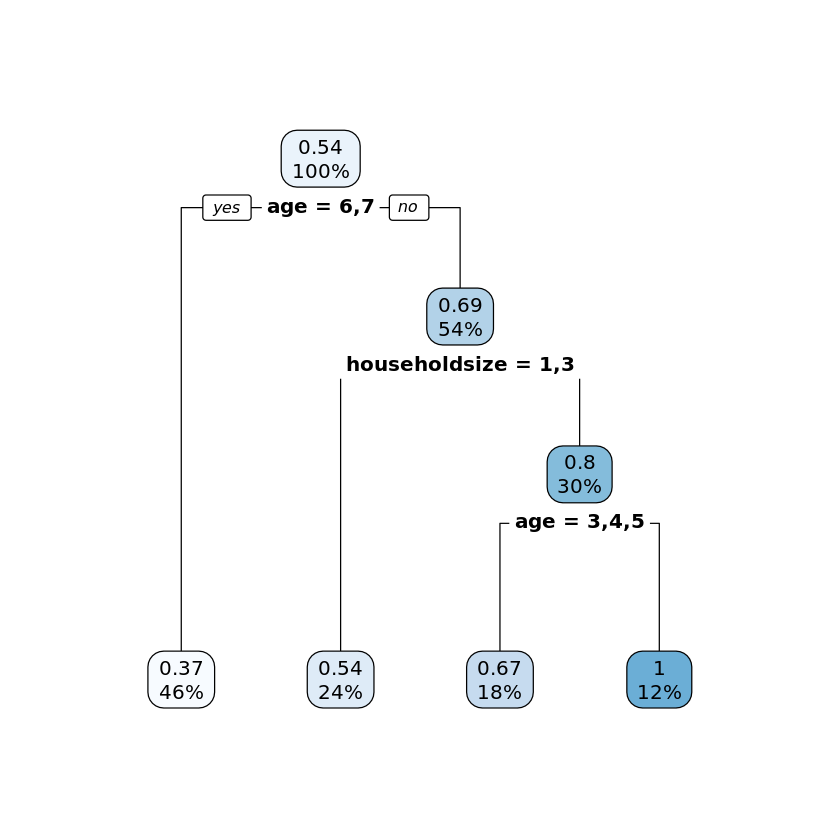

In [10]:
rpart.plot::rpart.plot(final_model$model, roundint=FALSE)